In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [2]:
from random import choices
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex

In [208]:
from jupyter_utils import add_grey

In [3]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/'

In [4]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/'

In [5]:
long_df_ru = pd.read_csv(PATH + 'long_ru.csv', index_col=0)

In [6]:
long_df_de = pd.read_csv(PATH + 'long_de.csv', index_col=0)

In [7]:
long_df = pd.concat([long_df_ru, long_df_de])
long_df.tail()

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_low,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high
1627,de,sadness,sample_raw,sample_raw,graph,PE,0.072718,0.092412,0.028025,0.144375,...,0.161599,0.301020,0.482556,0.483487,0.430986,0.540829,0.413537,0.414719,0.368688,0.460928
1628,de,sadness,sample_raw,sample_raw,graph,degree_average,0.053097,0.080566,0.014317,0.124021,...,0.231586,0.390299,0.434464,0.432834,0.386642,0.482012,0.411861,0.410253,0.367080,0.455254
1629,de,sadness,sample_raw,sample_raw,graph,degree_std,0.100820,0.117550,0.044424,0.174172,...,0.309745,0.450923,0.463002,0.460349,0.414120,0.509225,0.466058,0.464205,0.423372,0.503094
1630,de,sadness,sample_raw,sample_raw,graph,number_of_edges,0.209177,0.212705,0.144147,0.277617,...,0.402361,0.510313,0.530675,0.529984,0.499753,0.560742,0.560653,0.561677,0.528005,0.592891
1631,de,sadness,sample_raw,sample_raw,graph,number_of_nodes,0.207853,0.209475,0.143152,0.270386,...,0.339156,0.452717,0.412672,0.404037,0.358598,0.452844,0.453008,0.452813,0.410813,0.496868


In [8]:
raw_long_df = long_df[long_df['performance_metric'] == 'sample_raw']

In [9]:
long_df = long_df[long_df['performance_metric'] != 'sample_raw']

## Assign colors to metrics

fix metric colors - dict (color by group)  \
fix metric order

In [10]:
metric_groups = {group: long_df[long_df['metric_group'] == group]['metric_name'].unique().tolist() for group in long_df['metric_group'].unique()}

In [11]:
LM_groups_metrics = {}
LM_groups_models = {}
for metric_name in metric_groups['LM']:
    model, metric = metric_name.rsplit('_', 1)
    LM_groups_metrics.setdefault(metric, []).append(metric_name)
    LM_groups_models.setdefault(model, []).append(metric_name)

In [353]:
group_to_color = {'graph': "#fbacb9", # '#ad017e', 
                  'lexical': '#8e2f6d', 'syntactic': '#e2191c', 'LM': "#1d5b5d"}
group_to_palette = {'graph': 'RdPu', 'lexical': 'Purples', 'syntactic': 'YlOrRd'}

In [13]:
model_to_color = {'bert': '#3b6a2a', 'glove_avg': '#1d5b5d', 'glove_tf': '#274754', 'w2v_avg': '#0c2c41', 'w2v_tf': '#1d3658'}

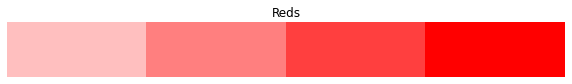

In [14]:
def sample_categorical_palette(color_name, size, cmap=None, low=0.25):
    """
    Samples evenly from a continuous colormap ranging from light-shade to a full color,
    to create a categorical palette.
    
    Parameters:
    - color_name (str): Name of the target color (e.g., "blue", "red", "#ff5733").
    - size (int): Number of discrete colors in the resulting categorical palette.
    
    Returns:
    - list: A list of RGB tuples representing the categorical palette.
    """
    # Get the colormap
    if not cmap:
        cmap = LinearSegmentedColormap.from_list("custom_colormap", ["white", color_name])
    
    # Sample evenly spaced values between low and 1
    colors = [cmap(i) for i in np.linspace(low, 1, size)]
    
    return colors

# Visualize the sampled palette
def visualise_palette(palette, title):
    plt.figure(figsize=(10, 1))
    plt.imshow([palette], aspect="auto")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example usage:
categorical_palette = sample_categorical_palette('red', 4)
visualise_palette(categorical_palette, 'Reds')

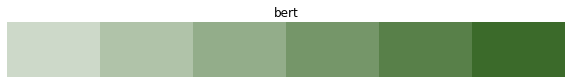

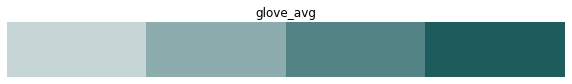

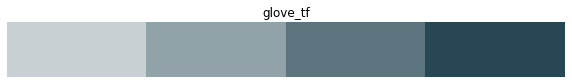

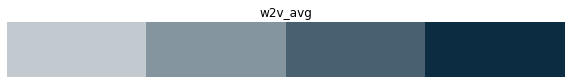

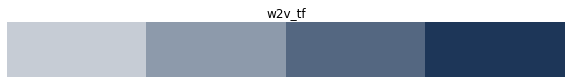

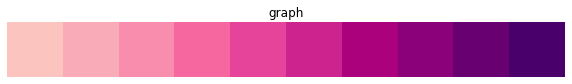

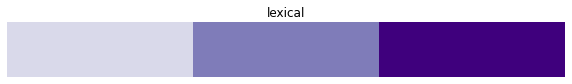

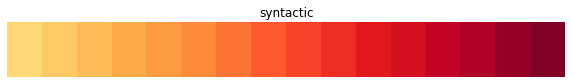

In [15]:
metric_to_color = {}
for group in metric_groups:
    if group == 'LM':
        for model in LM_groups_models:
            tgt_color = model_to_color[model]
            tgt_len = len(LM_groups_models[model])
            palette = sample_categorical_palette(tgt_color, tgt_len)
            visualise_palette(palette, model)
            for i, metric in enumerate(LM_groups_models[model]):
                metric_to_color[metric] = to_hex(palette[i])
    else:
        tgt_plt = group_to_palette[group]
        tgt_len = len(metric_groups[group])
        palette = sample_categorical_palette('', tgt_len, cmap=plt.get_cmap(tgt_plt))
        visualise_palette(palette, group)
        for i, metric in enumerate(metric_groups[group]):
            metric_to_color[metric] = to_hex(palette[i])
        

## Assess task dificulty


for each task - count metrics that perform on it

In [16]:
def CI_does_not_intersect_zero(line):
    return line['CI_low'] * line['CI_high'] > 0

In [297]:
# long_df[~long_df.apply(CI_does_not_intersect_zero, axis=1)]

In [392]:
def perfrom_above_treshold(line, r=0.3, t=0.2, ps_r=0.09):
    if not CI_does_not_intersect_zero(line):
        return False
    elif line['performance_metric'] == 't':
        return True
    elif line['performance_metric'] == 'r' and abs(line['median']) > r:
        return True
    elif line['performance_metric'] == 'ps_r' and abs(line['median']) > ps_r:
        return True
    return False

In [295]:
# long_df['task'].value_counts()

In [294]:
# long_df[long_df[['lang', 'task', 'scale', 'performance_metric', 'metric_group', 'metric_name']].duplicated(keep=False)]

In [390]:
long_df[long_df.apply(perfrom_above_treshold, axis=1)]['task'].value_counts()

present      155
chair        109
adventure    106
sportsman    101
anger         94
fear          68
sadness       58
happiness     23
Name: task, dtype: int64

In [391]:
long_df[long_df.apply(perfrom_above_treshold, axis=1) & (long_df["scale"]== "panss_total")]['task'].value_counts()

present      20
anger        15
fear         13
chair        12
adventure    10
sportsman    10
sadness      10
happiness     1
Name: task, dtype: int64

In [243]:
best_task = {"ru": "present", "de": "anger"}

## Plot all metrics on the best task for each language

for the best task, for each langugae 4 x 2 panels - each metric group vs t-test performance and correlation with panss total - three baselines 

In [296]:
control_cols = ['mean_sent_len', 'n_sents', 'n_words']

In [199]:
def plot_horisontal_ci_ax(df, ax, palette=None, key='median',
                          xlabel = 'Mean Value with Confidence Interval',
    # Add custom error bars based on the confidence intervals
    for i, row in df.iterrows():
        if not palette:
            color = 'skyblue'
        elif isinstance(palette, list):
            color = palette[i]
        elif isinstance(palette, dict):
            color = palette.get(row['metric_name'], 'skyblue')
        ax.errorbar(row[key], row['metric_name'], 
                     xerr=[[abs(row[key] - row['CI_low'])], [abs(row['CI_high'] - row[key])]], 
                     fmt='o', color=color, capsize=0, elinewidth=2)

    # Add labels and title
    if xlabel:
        ax.set_xlabel(xlabel)
    if add_zero:
        ax.axvline(0, color="darkgrey")

In [270]:
def add_baseline_lines(ax, value, add_neg=True, color=None, alpha=1):
    color = color or "lightblue"
    ax.axvline(value, linestyle=':', color=color, alpha=alpha)
    if add_neg:
        ax.axvline(-value, linestyle=':', color=color, alpha=alpha)

In [271]:
def get_data(df, lang, task, metric_group=None, scale='panss_total'):
    if not metric_group:
        return df[(df["lang"] == lang) & (df["task"] == task) & (df["scale"] == scale)]
    else:
        return df[(df["lang"] == lang) & (df["task"] == task) & 
                  (df["scale"] == scale) & (df["metric_group"] == metric_group)]

In [291]:
def add_control_lines(ax, df, lang, task, scale='panss_total', control_cols=control_cols, alpha=1):
    for control_col in control_cols:
        cdata = get_data(df, lang, task, scale=scale)
        control_median = cdata[cdata["metric_name"] == control_col]["median"].values[0]
        control_color = metric_to_color[control_col]
        add_baseline_lines(ax, control_median, color=control_color, alpha=alpha)

In [257]:
# ex = get_data(long_df, "ru", "present", "syntactic")
# fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
# ax = axes

# plot_horisontal_ci_ax(ex, ax, palette=metric_to_color, xlabel=None)
# for control_col in control_cols:
#     cdata = get_data(long_df, "ru", "present")
#     control_median = cdata[cdata["metric_name"] == control_col]["median"].values[0]
#     control_color = metric_to_color[control_col]
#     add_baseline_lines(ax, control_median, color=control_color)
# fig.suptitle('Syntactic metrics on russian present task, correlation with panss total')

# add_grey(ax)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [278]:
dpi = 300

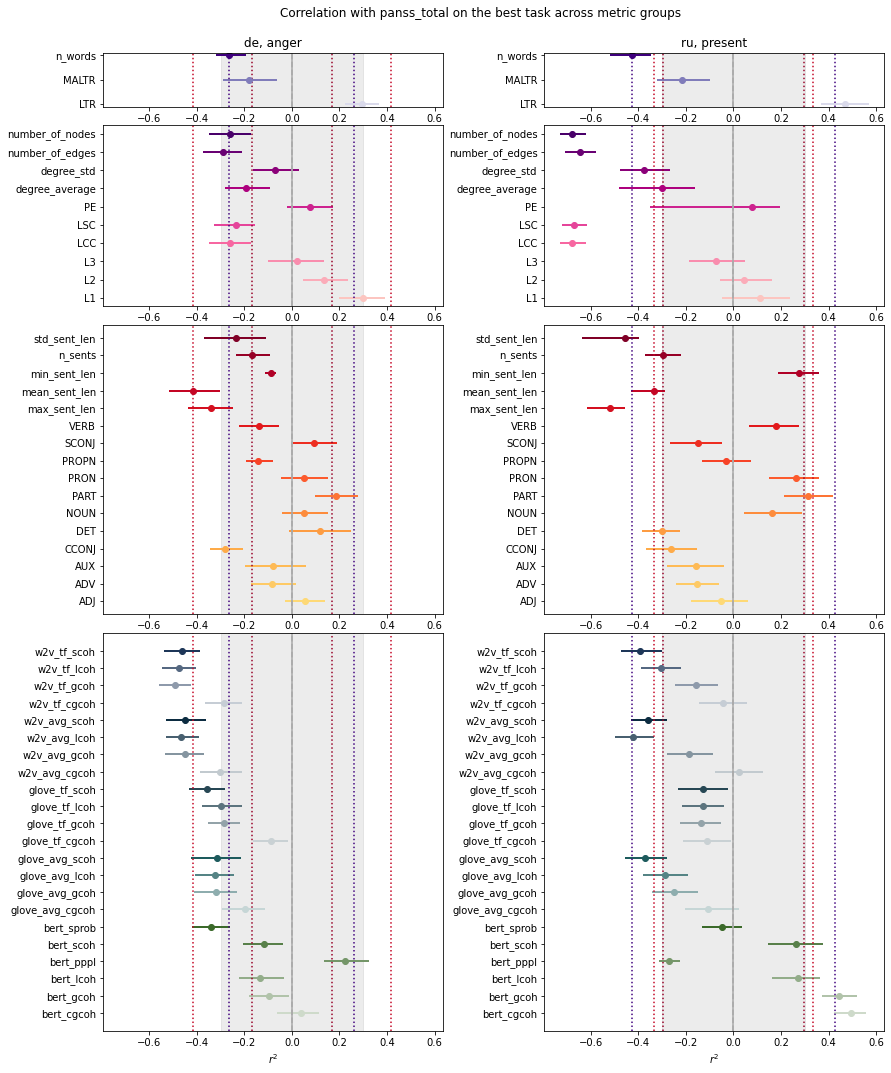

<Figure size 432x288 with 0 Axes>

In [287]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        task = best_task[lang]
        data = get_data(long_df, lang, task, metric_group)
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, long_df, lang, task)
        add_grey(ax)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}, {task}")
        if i == 3:
            ax.set_xlabel("$r^2$")

fig.suptitle("Correlation with panss_total on the best task across metric groups", y=0.915);
plt.show()

plt.savefig(f'{PATH_FIG}panss_total_best_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')

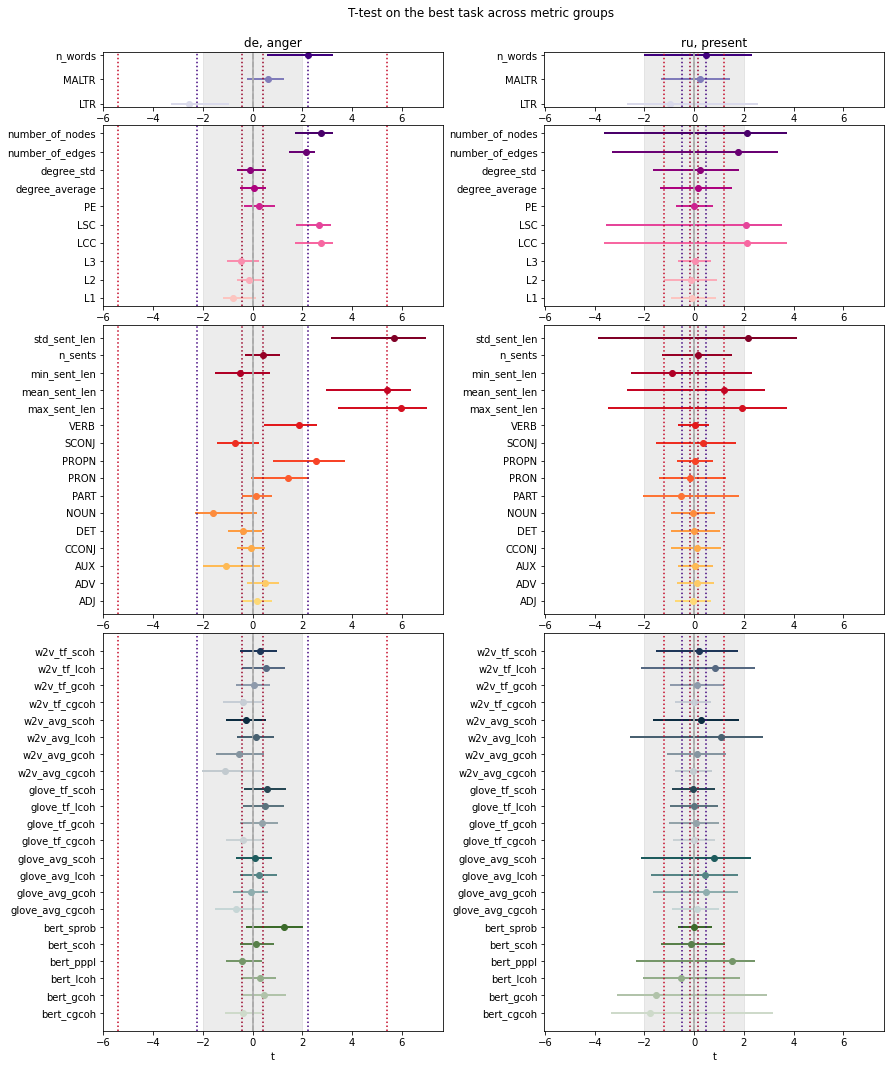

<Figure size 432x288 with 0 Axes>

In [293]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        task = best_task[lang]
        data = get_data(long_df, lang, task, metric_group, scale='group_diff')
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, long_df, lang, task, scale='group_diff')
        add_grey(ax, r=2)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}, {task}")
        if i == 3:
            ax.set_xlabel("t")

fig.suptitle("T-test on the best task across metric groups", y=0.915);
plt.show()

plt.savefig(f'{PATH_FIG}t-test_best_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')

## Correlation of performance with verbosity

each language, each task: 3 baselines by 2 t-test and panss total performance - scatter plot + correlation line: performace vs corr baseline - color metrics by group

In [336]:
def corr_nan(df, col1, col2, abs_=True):
    dropped_c = df.dropna(subset=[col1, col2])
    c1 = abs(dropped_c[col1]) if abs_ else dropped_c[col1]
    c2 = abs(dropped_c[col2]) if abs_ else dropped_c[col2]
    r_c = stats.pearsonr(c1, c2)[0]
    return r_c

In [337]:
corr_nan(ex, 'median', 'corr_n_words_median')

0.35837381275753943

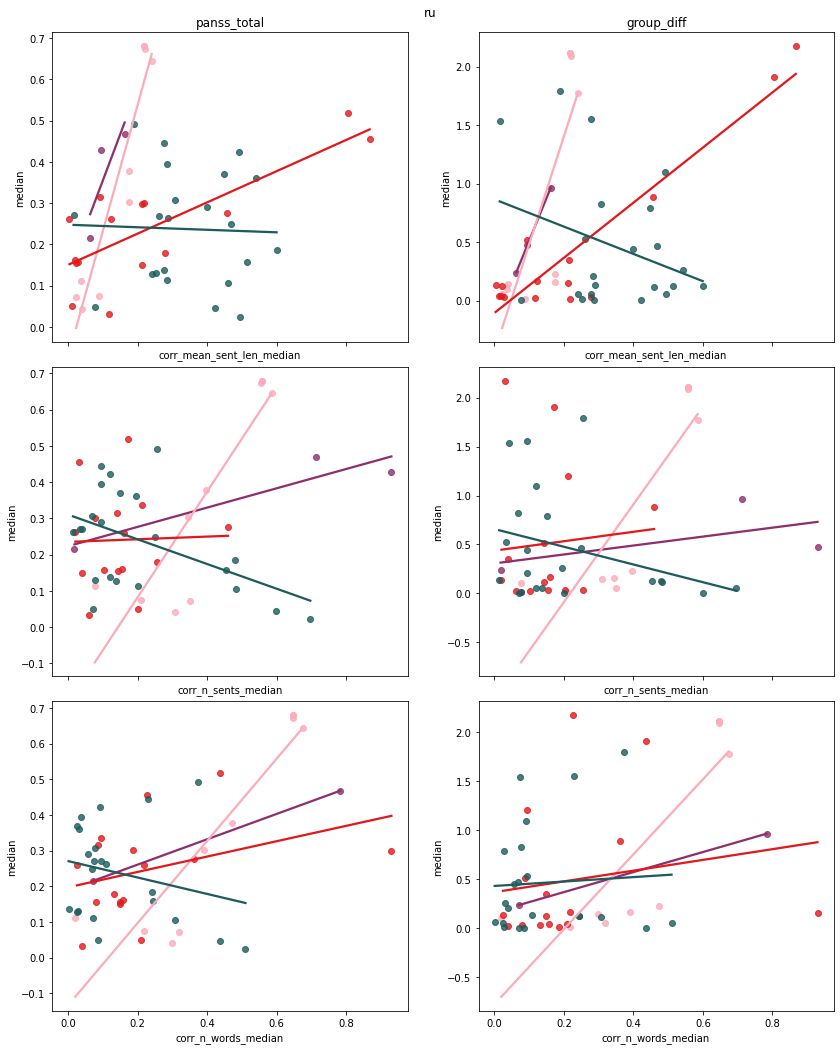

In [381]:
lang="ru"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        for metric_group in ['lexical', 'graph', 'syntactic', 'LM']:
            data = get_data(long_df, lang, task, metric_group, scale=scale)
            data = data[data["metric_name"] != control_col]
            sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), 
                        color=group_to_color[metric_group], ax=ax, ci=None)
#         data = get_data(long_df, lang, task, scale='group_diff')
#         data = data[data["metric_name"] != control_col]
#         sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

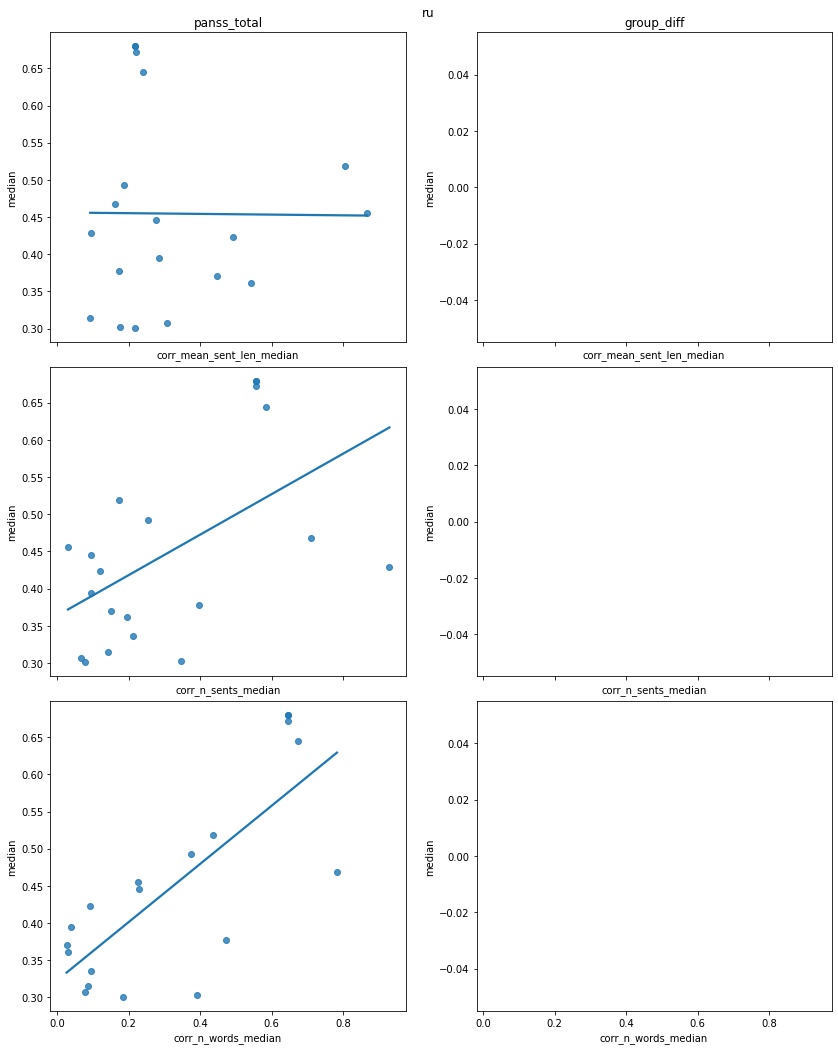

In [396]:
lang = "ru"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        data = get_data(long_df, lang, task, scale=scale)
        data = data[(data["metric_name"] != control_col) & data.apply(perfrom_above_treshold, axis=1)]
        sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

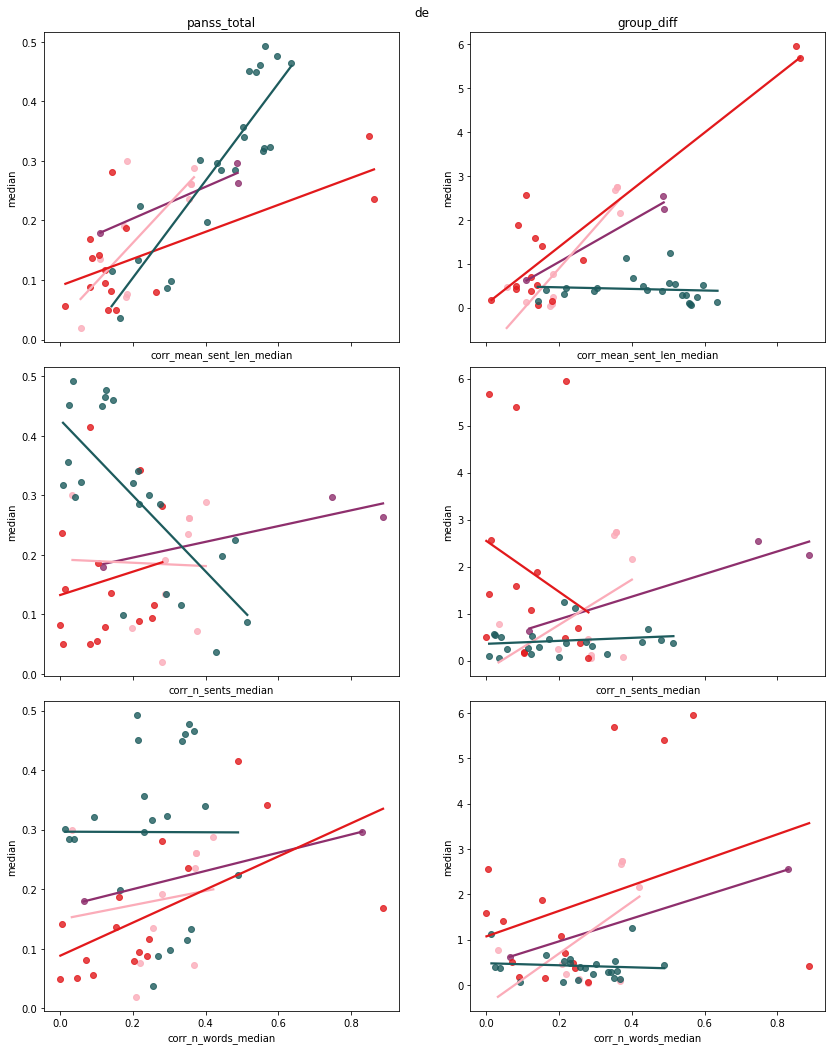

In [383]:
lang = "de"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        for metric_group in ['lexical', 'graph', 'syntactic', 'LM']:
            data = get_data(long_df, lang, task, metric_group, scale=scale)
            data = data[data["metric_name"] != control_col]
            sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), 
                        color=group_to_color[metric_group], ax=ax, ci=None)
#         data = get_data(long_df, lang, task, scale='group_diff')
#         data = data[data["metric_name"] != control_col]
#         sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

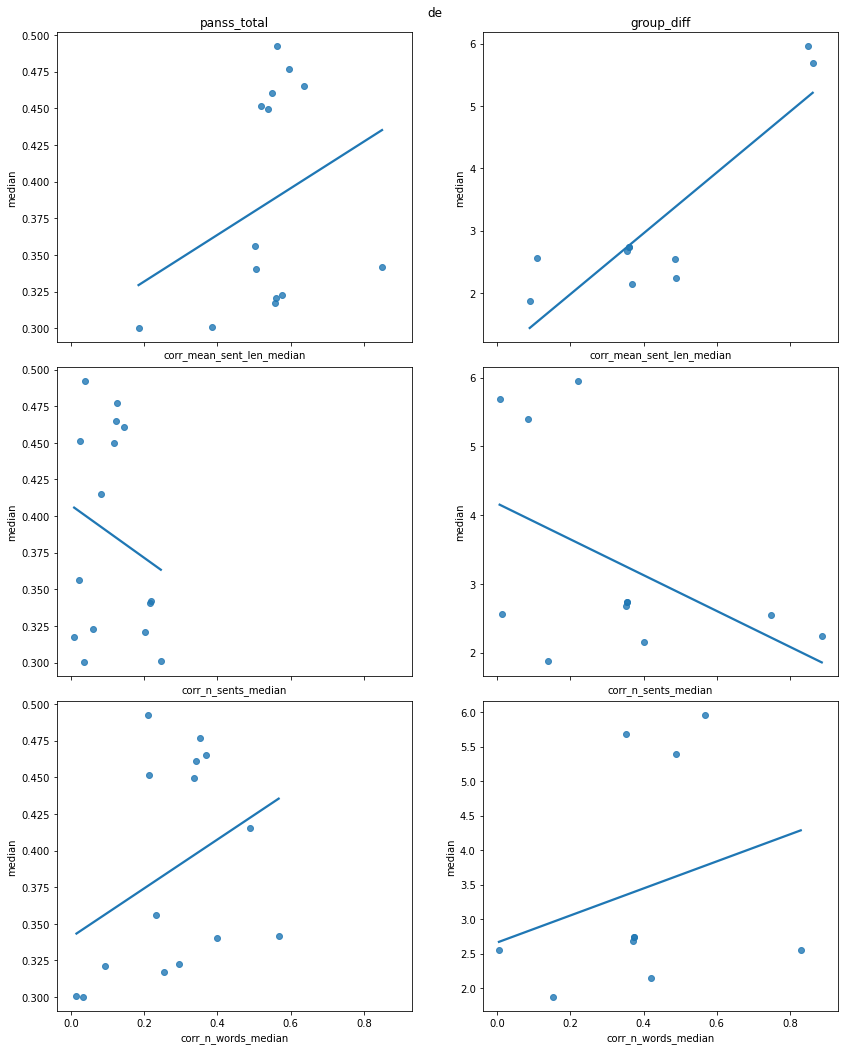

In [397]:
lang = "de"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        data = get_data(long_df, lang, task, scale=scale)
        data = data[(data["metric_name"] != control_col) & data.apply(perfrom_above_treshold, axis=1)]
        sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

## Best metrics perform across tasks
difference between tasks: SD(performance) / (mean task performance) - scatter vs mean task performance on t-test and panss total - color metrics by group

In [459]:
def diff_task_performance(df, metric_name, lang, scale):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)]['median'].abs()
    return np.std(data) / np.mean(data)

In [460]:
def mean_task_performance(df, metric_name, lang, scale):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)]['median'].abs()
    return np.mean(data)

In [474]:
dict_diff = {"group": [], 
             "diff_group_diff_de": [], "diff_group_diff_ru": [], 
             "diff_panss_total_de": [], "diff_panss_total_ru": [],
             
             "group_diff_de": [], "group_diff_ru": [], 
             'panss_total_de': [], 'panss_total_ru': []}
for lang in ["ru", "de"]:
    for metric_name in metric_to_color:
        for scale in ['panss_total', 'group_diff']:
            diff = diff_task_performance(long_df, metric_name, lang, scale)
            mean = mean_task_performance(long_df, metric_name, lang, scale)
            dict_diff[f"diff_{scale}_{lang}"].append(diff)
            if lang == "ru" and scale == "group_diff":
                dict_diff["group"].append(long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0])
            dict_diff[f"{scale}_{lang}"].append(mean)

In [475]:
diff_df = pd.DataFrame.from_dict(dict_diff)
diff_df.index = list(metric_to_color.keys())

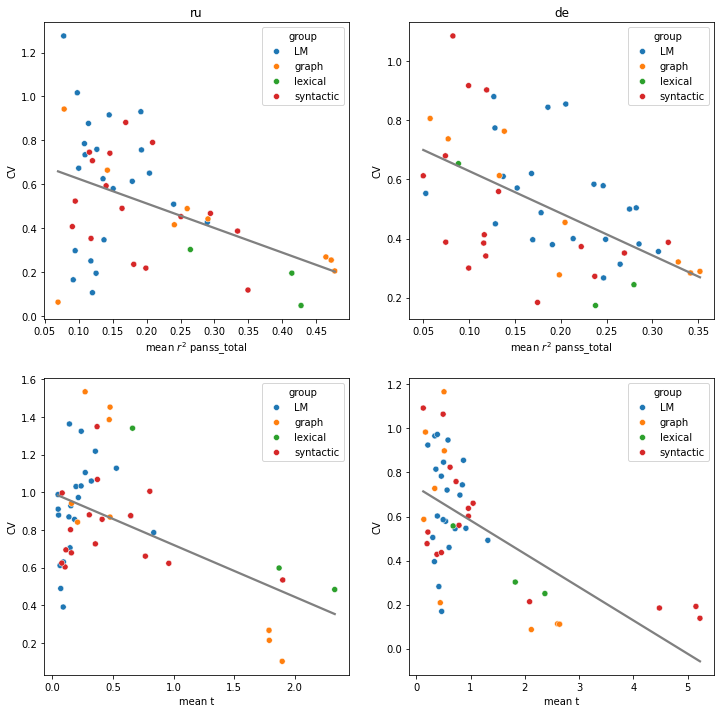

In [492]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, scale in enumerate(['panss_total', 'group_diff']):
    for j, lang in enumerate(["ru", "de"]):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        sns.scatterplot(y=diff_df[f"diff_{scale}_{lang}"], x=diff_df[f"{scale}_{lang}"], hue=diff_df["group"], ax=ax)
        sns.regplot(y=diff_df[f"diff_{scale}_{lang}"], x=diff_df[f"{scale}_{lang}"], 
                    ci=None, scatter=False, color='grey', ax=ax)
        ax.set_ylabel('CV')
        label = 'mean $r^2$ panss_total' if i == 0 else "mean t"
        ax.set_xlabel(label)

## Best metrics perform across scales
difference between scales: SD(performance) / (mean scale performance) - scatter vs mean scale performance on t-test and - color metrics by group

normalize each scale performance z transform ((val) - mean(vals)) / std(vals)

In [545]:
def normalize_scale_values(df, scale, lang, task):
    data = df[(df['lang'] == lang) & (df['scale'] == scale) & (df['task'] == task)]['median'].values
    return (data - np.nanmean(data)) / np.nanstd(data)

In [546]:
long_df["normalized_median"] = np.nan

In [547]:
for lang in ["de", "ru"]:
    for task in long_df[long_df["lang"] == lang]["task"].unique():
        for scale in long_df[long_df["lang"] == lang]["scale"].unique():
            vals = normalize_scale_values(long_df, scale, lang, task)
            long_df.loc[(long_df["lang"] == lang) 
                    & (long_df["task"] == task) 
                    & (long_df["scale"] == scale), "normalized_median"] = vals

In [548]:
def diff_scale_performance(df, metric_name, lang, task):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['task'] == task)]['normalized_median'].abs()
    return np.nanstd(data) / np.nanmean(data)

In [549]:
def mean_scale_performance(df, metric_name, lang, scale):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['task'] == task)]['normalized_median'].abs()
    return np.nanmean(data)

In [551]:
dict_diff = {"group": [], 
             'diff_anger_de': [], 'diff_fear_de': [],
             'diff_happiness_de': [], 'diff_sadness_de': [],
             'diff_adventure_ru': [], 'diff_chair_ru': [],
             'diff_present_ru': [], 'diff_sportsman_ru': [],
             
             'perf_anger_de': [], 'perf_fear_de': [],
             'perf_happiness_de': [], 'perf_sadness_de': [], 
             
             'perf_adventure_ru': [], 'perf_chair_ru': [], 
             'perf_present_ru': [], 'perf_sportsman_ru': []}

for lang in ["ru", "de"]:
    for metric_name in metric_to_color:
        for task in long_df[long_df["lang"] == lang]["task"].unique():
            diff = diff_scale_performance(long_df, metric_name, lang, task)
            mean = mean_scale_performance(long_df, metric_name, lang, task)
            dict_diff[f"diff_{task}_{lang}"].append(diff)
            if lang == "de" and task == "anger":
                dict_diff["group"].append(long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0])
            dict_diff[f"perf_{task}_{lang}"].append(mean)

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_3598/317686383.py:3: RuntimeWarning: Mean of empty slice
  return np.nanstd(data) / np.nanmean(data)


In [552]:
diff_df = pd.DataFrame.from_dict(dict_diff)
diff_df.index = list(metric_to_color.keys())

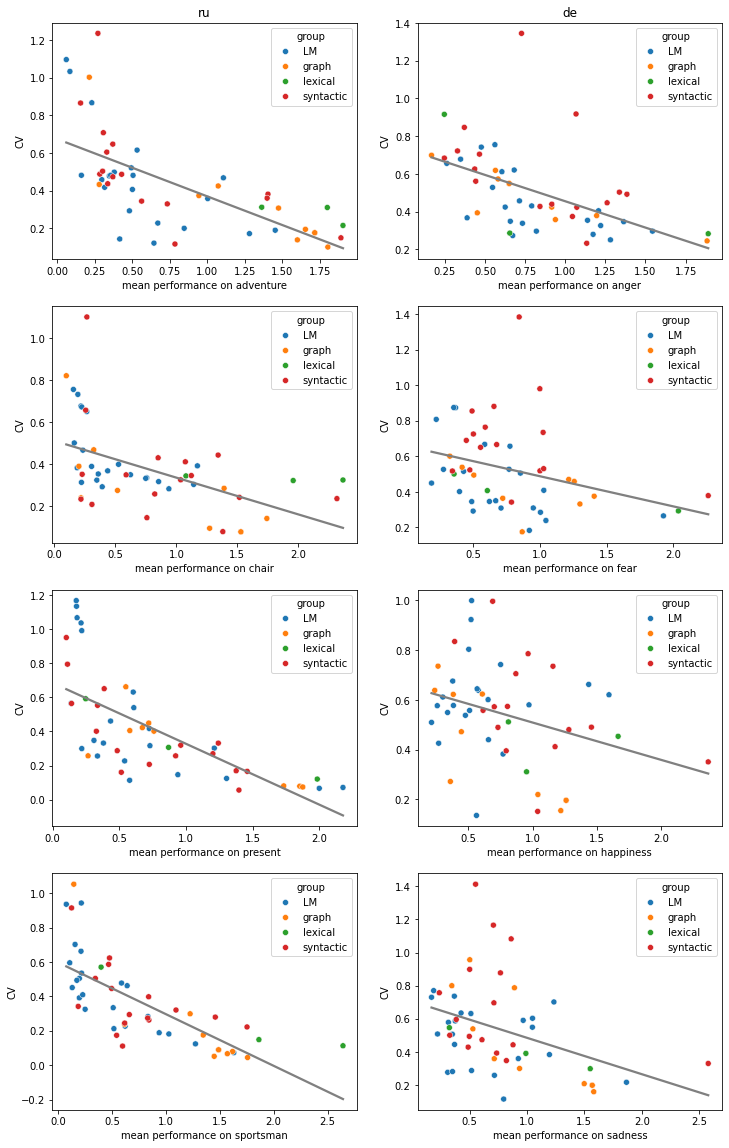

In [553]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
for i in range(4):
    for j, lang in enumerate(["ru", "de"]):
        task = long_df[long_df["lang"] == lang]["task"].unique()[i]
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        sns.scatterplot(y=diff_df[f"diff_{task}_{lang}"], x=diff_df[f"perf_{task}_{lang}"], hue=diff_df["group"], ax=ax)
        sns.regplot(y=diff_df[f"diff_{task}_{lang}"], x=diff_df[f"perf_{task}_{lang}"], 
                    ci=None, scatter=False, color='grey', ax=ax)
        ax.set_ylabel('CV')
        ax.set_xlabel(f'mean performance on {task}')